In [1]:
# ==============================================================================
# Copyright 2021 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================
#
# Author: Chanchal Chatterjee
# Email: cchatterjee@google.com
#
# Filename: test_tf.ipynb
# Classify CIFAR10 images
#

In [2]:
### Import packages

In [ ]:
!cd /home/jupyter/vapit/ai-platform-tf/Vertex
!python3 -m pip install -r ./requirements.txt -U -q --user
!python3 -m pip install -U -q google-cloud-aiplatform
!python3 -m pip install -U -q google-cloud-storage==1.32
!gcloud components update --quiet
!python3 -m pip install -U -q build


In [4]:
# Automatically restart kernel after installs
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)  

{'status': 'ok', 'restart': True}

In [1]:
# Import packages

import json
import logging
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
from googleapiclient import discovery
from google.cloud import aiplatform

### Configure Global Variables

List your current GCP project name

In [2]:
project_id = !gcloud config list --format 'value(core.project)' 2>/dev/null
project_id

['cchatterjee-sandbox']

Configure your system variables

In [3]:
# Configure your global variables
PROJECT = project_id[0]  # Replace with your project ID
USER = 'cchatterjee'             # Replace with your user name
BUCKET_NAME = 'vapit_data'       # Replace with your gcs bucket name - gloablly unique

FOLDER_NAME = 'tf_models'
TIMEZONE = 'US/Pacific'
REGION = 'us-central1'
PACKAGE_URIS = f"gs://{BUCKET_NAME}/trainer/tensorflow/trainer-0.1.tar.gz" 

JOB_DIR = 'gs://{}/{}/jobdir'.format(
    BUCKET_NAME,
    FOLDER_NAME
    )
MODEL_DIR = 'gs://{}/{}/models'.format(
    BUCKET_NAME,
    FOLDER_NAME
    )
print("JOB_DIR   = ", JOB_DIR)
print("MODEL_DIR = ", MODEL_DIR)


JOB_DIR   =  gs://vapit_data/tf_models/jobdir
MODEL_DIR =  gs://vapit_data/tf_models/models


### Authenticate your GCP account

This is required if you run the notebook in Colab

In [4]:
try:
  from google.colab import auth
  auth.authenticate_user()
  print("Colab user is authenticated.")
except: pass

Create your bucket

In [5]:
!gsutil mb -l $REGION gs://$BUCKET_NAME 

Creating gs://vapit_data/...
ServiceException: 409 A Cloud Storage bucket named 'vapit_data' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [53]:
# Clean old job logs, job packages and models
!gsutil -m -q rm $JOB_DIR/packages/**
!gsutil -m -q rm $MODEL_DIR/model**


CommandException: 1 files/objects could not be removed.


-----------
### Special functions


In [6]:
#------
def find_best_model_dir(model_dir, offset=1, maxFlag=1):
    # Get a list of model directories
    all_models = ! gsutil ls $model_dir
    print("")
    print("All Models = ")
    print(*all_models, sep='\n')

    # Check if model dirs exist
    if (("CommandException" in all_models[0]) or (len(all_models) <= 1)):
        print("Create the models first.")
        return ""

    # Find the best model from checkpoints
    import re
    best_acc = -np.Inf
    if (maxFlag != 1):
        best_acc = np.Inf
    best_model_dir = ""
    tup_list = []
    for i in range(1,len(all_models)):
        all_floats = re.findall(r"[-+]?\d*\.\d+|\d+", all_models[i]) #Find the floats in the string
        cur_acc = -float(all_floats[-offset]) #which item is the model optimization metric
        tup_list.append([all_models[i],cur_acc])
        if (maxFlag*(cur_acc > best_acc) or (1-maxFlag)*(cur_acc < best_acc)):
            best_acc = cur_acc
            best_model_dir = all_models[i]
    if maxFlag:
        tup_list.sort(key=lambda tup: tup[1], reverse=False)
    else:
        tup_list.sort(key=lambda tup: tup[1], reverse=True)
    #for i in range(len(tup_list)):
    #    print(tup_list[i][0])
    print("Best Accuracy  from Checkpoints = ", best_acc)
    print("Best Model Dir from Checkpoints = ", best_model_dir)
    
    return best_model_dir


In [7]:
# Plot original images
# image_array is np.array(num_images, x_size, y_size)

import matplotlib.pyplot as plt

def plot_images(image_array):
    fig, axarr = plt.subplots(4,4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            #axarr[i,j].set_title('Image-'+str(4*i+j))
            axarr[i,j].imshow(image_array[4*i+j,:,:], cmap='gray')


## Build python package and upload to your bucket

In [8]:
%%writefile ./setup.py

# python3

# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

# https://cloud.google.com/ai-platform/training/docs/runtime-version-list

from setuptools import find_packages
from setuptools import setup

#Runtime 2.1
REQUIRED_PACKAGES = ['tensorflow==2.1.0',
                     'numpy==1.18.0',
                     'pandas==0.25.3',
                     'scikit-learn==0.22',
                     'google-cloud-storage==1.23.0',
                     'gcsfs==0.6.1',
                     'cloudml-hypertune',
                    ]
setup(
    name='trainer',
    version='0.1',
    install_requires=REQUIRED_PACKAGES,
    packages=find_packages(),
    include_package_data=True,
    description='Trainer package for Tensorflow Task'
)


Overwriting ./setup.py


In [9]:
# Create the tf_trainer directory and load the trainer files in it
!mkdir -p trainer

In [10]:
%%writefile ./trainer/__init__.py
# python3

# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================


Overwriting ./trainer/__init__.py


In [11]:
%%writefile ./trainer/inputs.py

# Create the train and label lists
import math
import numpy as np
import pandas as pd
import tensorflow as tf

#------
def load_data():

    """Creates train and test data set"""
    cifar10 = tf.keras.datasets.cifar10
    (X_train, y_train),(X_test, y_test) = cifar10.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    
    y_train = y_train.flatten()
    y_test = y_test.flatten()
    
    # Check the shape
    print("X_train shape = ", X_train.shape)
    print("X_test  shape = ", X_test.shape)
    
    print("y_train shape = ", y_train.shape)
    print("y_test  shape = ", y_test.shape)

    return [X_train, X_test, y_train, y_test]


Writing ./trainer/inputs.py


In [19]:
%%writefile ./trainer/model.py

import tensorflow as tf
import numpy as np

def tf_model(input_shape, model_depth: int = 1, dropout_rate: float = 0.02):
    """Creates the keras model used by task to train the model."""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Flatten, Dropout
    x_dim = input_shape[0]
    y_dim = input_shape[1]

    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    for i in range(0,model_depth):
        nUnits = x_dim*y_dim-(i+1)*((x_dim*y_dim-128)//model_depth)
        model.add(Dense(nUnits, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(10, activation='softmax'))

    print(model.summary())

    return model

def custom_loss(y_true, y_pred):
    custom_loss = np.mean(np.square(y_true - y_pred), axis=-1)
    return custom_loss

def custom_metric(y_true, y_pred):
    custom_metric = np.mean(np.square(y_true - y_pred), axis=-1)
    return custom_metric


Overwriting ./trainer/model.py


In [20]:
%%writefile ./trainer/train.py

# python3
# ==============================================================================
# Copyright 2020 Google LLC. This software is provided as-is, without warranty
# or representation for any use or purpose. Your use of it is subject to your
# agreement with Google.
# ==============================================================================

import os
import json
import tensorflow as tf
import numpy as np
import datetime as datetime
from pytz import timezone
import hypertune
import argparse
from trainer import model
from trainer import inputs


import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

def parse_arguments():
    """Argument parser.
    Returns:
      Dictionary of arguments.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_depth', default=1, type=int,
                        help='Hyperparameter: depth of the model')
    parser.add_argument('--dropout_rate', default=0.02, type=float, 
                        help='Hyperparameter: Drop out rate')
    parser.add_argument('--learning_rate', default=0.0001, type=float, 
                        help='Hyperparameter: initial learning rate')
    parser.add_argument('--epochs', default=2, type=int,
                        help='Hyperparameter: epoch.')
    parser.add_argument('--batch_size', default=4, type=int, 
                        help='batch size of the deep network')
    parser.add_argument('--model_dir', default="",
                        help='Directory to store model checkpoints and logs.')
    parser.add_argument('--verbosity',choices=['DEBUG', 'ERROR', 'FATAL', 'INFO', 'WARN'],
                        default='FATAL')
    args, _ = parser.parse_known_args()
    return args

def get_callbacks(args, early_stop_patience: int = 3):
    """Creates Keras callbacks for model training."""

    # Get trialId
    trialId = json.loads(os.environ.get("TF_CONFIG", "{}")).get("task", {}).get("trial", "")
    if trialId == '':
        trialId = '0'
    print("trialId=", trialId)

    curTime = datetime.datetime.now(timezone('US/Pacific')).strftime('%H%M%S')
    
    # Modify model_dir paths to include trialId
    model_dir = args.model_dir + "/checkpoints/cp-"+curTime+"-"+trialId+"-{val_accuracy:.4f}"
    log_dir   = args.model_dir + "/log_dir"

    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    checkpoint_cb  = tf.keras.callbacks.ModelCheckpoint(model_dir, monitor='val_accuracy', mode='max', 
                                                        verbose=0, save_best_only=True,
                                                        save_weights_only=False)
    earlystop_cb   = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

    return [checkpoint_cb, tensorboard_cb, earlystop_cb]


if __name__ == "__main__":

    # ---------------------------------------
    # Parse Arguments
    # ---------------------------------------
    args = parse_arguments()
    #args.model_dir = MODEL_DIR + datetime.datetime.now(timezone('US/Pacific')).strftime('/model_%m%d%Y_%H%M')
    print(args)

    # ---------------------------------------
    # Input Data & Preprocessing
    # ---------------------------------------
    print("Input and pre-process data ...")
    # Extract train_seismic, train_label
    train_test_data = inputs.load_data()
    X_train = train_test_data[0]
    X_test  = train_test_data[1]
    y_train = train_test_data[2]
    y_test  = train_test_data[3]

    # ---------------------------------------
    # Train model
    # ---------------------------------------
    print("Creating model ...")
    input_shape = (X_train.shape)[1:]
    tf_model = model.tf_model(input_shape, model_depth=args.model_depth,
                              dropout_rate=args.dropout_rate)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=args.learning_rate)
    tf_model.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
    
    print("Fitting model ...")
    callbacks = get_callbacks(args, 3)
    histy = tf_model.fit(x=X_train, y=y_train,
                         epochs=args.epochs,
                         batch_size=args.batch_size,
                         validation_data=(X_test, y_test),
                         callbacks=callbacks)
    # TBD save history for visualization

    final_epoch_accuracy = histy.history['accuracy'][-1]
    final_epoch_count = len(histy.history['accuracy'])

    print('final_epoch_accuracy = %.6f' % final_epoch_accuracy)
    print('final_epoch_count = %2d' % final_epoch_count)

Overwriting ./trainer/train.py


In [21]:
# Create the tf directory and load the trainer files in it
!cp ./trainer/train.py ./trainer/train_hpt.py


In [22]:
%%writefile -a ./trainer/train_hpt.py

    """This method updates a CAIP HPTuning Job with a final metric for the job.
    In TF2.X the user must either use hypertune or a custom callback with
    tf.summary.scalar to update CAIP HP Tuning jobs. This function uses
    hypertune, which appears to be the preferred solution. Hypertune also works
    with containers, without code change.
    Args:
        metric_tag: The metric being optimized.  This MUST MATCH the
          hyperparameterMetricTag specificed in the hyperparameter tuning yaml.
        metric_value: The value to report at the end of model training.
        global_step: An int value to specify the number of trainin steps completed
          at the time the metric was reported.
    """

    hpt = hypertune.HyperTune()
    hpt.report_hyperparameter_tuning_metric(
        hyperparameter_metric_tag='accuracy',
        metric_value=final_epoch_accuracy,
        global_step=final_epoch_count
    )


Appending to ./trainer/train_hpt.py


In [23]:
!cd /home/jupyter/vapit/ai-platform-tf/Vertex
!python3 -m build
!gsutil cp ./dist/trainer-0.1.tar.gz $PACKAGE_URIS

Found existing installation: setuptools 47.1.0
Uninstalling setuptools-47.1.0:
  Successfully uninstalled setuptools-47.1.0
  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Using cached setuptools-57.2.0-py3-none-any.whl (818 kB)
You should consider upgrading via the '/tmp/build-env-uc7x8m4c/bin/python -m pip install --upgrade pip' command.
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'
running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing requirements to trainer.egg-info/requires.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest

------
### Training with Google Vertex AI 

For the full article, please visit: https://cloud.google.com/vertex-ai/docs

Where Vertex AI fits in the ML workflow \
The diagram below gives a high-level overview of the stages in an ML workflow. The blue-filled boxes indicate where Vertex AI provides managed services and APIs:

<img src="img/ml-workflow.svg" alt="Drawing">

As the diagram indicates, you can use Vertex AI to manage the following stages in the ML workflow:

- Train an ML model on your data:
 - Train model
 - Evaluate model accuracy
 - Tune hyperparameters
 
 
- Deploy your trained model.

- Send prediction requests to your model:
 - Online prediction
 - Batch prediction (for TensorFlow only)
 
 
- Monitor the predictions on an ongoing basis.

- Manage your models and model versions.

- For the latest list, see 
  - Pre-built containers for training: https://cloud.google.com/vertex-ai/docs/training/pre-built-containers
    and 
  - Pre-built containers for prediction: https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers


#### Train at local

Before submitting training jobs to Cloud AI Platform, you can test your train.py code in the local environment. You can test by running your python script in command line, but another and maybe better choice is to use `gcloud ai-platform local train` command. The latter method could make sure your your entire python package are ready to be submitted to the remote VMs.

X_train shape =  (50000, 32, 32, 3)
X_test  shape =  (10000, 32, 32, 3)
y_train shape =  (50000,)
y_test  shape =  (10000,)


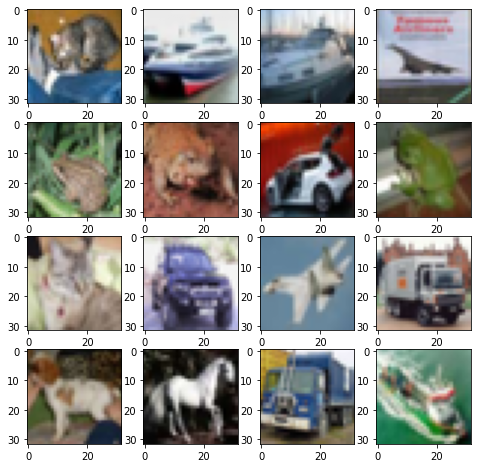

In [24]:
from trainer import inputs
train_test_data = inputs.load_data()
X_test  = train_test_data[1]
plot_images(X_test)


In [25]:
%%time
# Run the training manually
# Training parameters
from datetime import datetime
from pytz import timezone

MODEL_DEPTH = 2
DROPOUT_RATE = 0.01
LEARNING_RATE = 0.00005
EPOCHS = 1
BATCH_SIZE = 32

MODEL_DIR_PYTH = 'gs://{}/{}/models/{}'.format(
    BUCKET_NAME,
    FOLDER_NAME,
    datetime.now(timezone('US/Pacific')).strftime('model_%m%d%Y_%H%M')
    )

print('MODEL_DEPTH = %2d' % MODEL_DEPTH)
print('DROPOUT_RATE = %.4f' % DROPOUT_RATE)
print('LEARNING_RATE = %.6f' % LEARNING_RATE)
print('EPOCHS = %2d' % EPOCHS)
print('BATCH_SIZE = %2d' % BATCH_SIZE)
print("MODEL_DIR =", MODEL_DIR_PYTH)

# Run training
! python3 -m trainer.train \
    --model_depth=$MODEL_DEPTH \
    --dropout_rate=$DROPOUT_RATE \
    --learning_rate=$LEARNING_RATE \
    --epochs=$EPOCHS \
    --batch_size=$BATCH_SIZE \
    --model_dir=$MODEL_DIR_PYTH 


MODEL_DEPTH =  2
DROPOUT_RATE = 0.0100
LEARNING_RATE = 0.000050
EPOCHS =  1
BATCH_SIZE = 32
MODEL_DIR = gs://vapit_data/tf_models/models/model_07162021_1042
2021-07-16 17:42:20.838503: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-07-16 17:42:20.838614: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-07-16 17:42:20.838635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make

------
### Hyperparameter Tuning

To use hyperparameter tuning in your training job you must perform the following steps:

- Specify the hyperparameter tuning configuration for your training job by including a HyperparameterSpec in your TrainingInput object.

- Include the following code in your training application:

 - Parse the command-line arguments representing the hyperparameters you want to tune, and use the values to set the hyperparameters for your training trial.
 - Add your hyperparameter metric to the summary for your graph.


In [94]:
# Google Vertex AI requires each job to have unique name, 
# Therefore, we use prefix + timestamp to form job names.
JOBNAME_HPT = 'tensorflow_train_{}_{}_hpt'.format(
    USER,
    datetime.now(timezone(TIMEZONE)).strftime("%m%d%y_%H%M")
    ) # define unique job name

# We use the job names as folder names to store outputs.
MODEL_DIR_HPT = 'gs://{}/{}/models/{}'.format(
    BUCKET_NAME,
    FOLDER_NAME,
    datetime.now(timezone('US/Pacific')).strftime('model_%m%d%Y_%H%M')
    )
JOB_DIR = 'gs://{}/{}/jobdir'.format(
    BUCKET_NAME,
    FOLDER_NAME
    )

print("JOB_NAME_HPT = ", JOBNAME_HPT)
print("JOB_DIR = ", JOB_DIR)
print("MODEL_DIR_HPT = ", MODEL_DIR_HPT)


JOB_NAME_HPT =  tensorflow_train_cchatterjee_071521_2019_hpt
JOB_DIR =  gs://vapit_data/tf_models/jobdir
MODEL_DIR_HPT =  gs://vapit_data/tf_models/models/model_07152021_2019


### Submit the hyperparameter job to vertex AI

In [95]:
executor_image_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-2:latest'
python_module =  "trainer.train_hpt"
api_endpoint = "{}-aiplatform.googleapis.com".format(REGION)
machine_type = "n1-standard-4"

# The AI Platform services require regional API endpoints.
client_options = {"api_endpoint": api_endpoint}
# Initialize client that will be used to create and send requests.
# This client only needs to be created once, and can be reused for multiple requests.
client = aiplatform.gapic.JobServiceClient(client_options=client_options)

# study_spec
metric = {
    "metric_id": "accuracy",
    "goal": aiplatform.gapic.StudySpec.MetricSpec.GoalType.MAXIMIZE,
}

depth = {
        "parameter_id": "model_depth",
        "integer_value_spec": {"min_value": 1, "max_value": 5},
        "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
}
# dropout_rate = {
#         "parameter_id": "dropout_rate",
#         "double_value_spec": {"min_value": 0.001, "max_value": 0.1},
#         "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LOG_SCALE,
# }
# learning_rate = {
#         "parameter_id": "learning_rate",
#         "double_value_spec": {"min_value": 0.00001, "max_value": 0.01},
#         "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LOG_SCALE,
# }
# batch_size = {
#         "parameter_id": "batch_size",
#         "integer_value_spec": {"min_value": 1, "max_value": 16},
#         "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
# }
epochs = {
        "parameter_id": "epochs",
        "integer_value_spec": {"min_value": 1, "max_value": 4},
        "scale_type": aiplatform.gapic.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
}

# trial_job_spec
machine_spec = {
    "machine_type": machine_type,
}
worker_pool_spec = {
    "machine_spec": machine_spec,
    "replica_count": 1,
    "python_package_spec": {
        "executor_image_uri": executor_image_uri,
        "package_uris": [PACKAGE_URIS],
        "python_module": python_module,
        "args": [
            '--job-dir',
            JOB_DIR,
            '--model_dir',
            MODEL_DIR_HPT,
            '--dropout_rate',
            str(DROPOUT_RATE),
            '--learning_rate',
            str(LEARNING_RATE),
            '--batch_size',
            str(BATCH_SIZE),
        ],
    },
}

# hyperparameter_tuning_job
hyperparameter_tuning_job = {
    "display_name": JOBNAME_HPT,
    "max_trial_count": 4,
    "parallel_trial_count": 2,
    "study_spec": {
        "metrics": [metric],
        "parameters": [depth, epochs],
#         "algorithm": aiplatform.gapic.StudySpec.Algorithm.RANDOM_SEARCH,
    },
    "trial_job_spec": {"worker_pool_specs": [worker_pool_spec]},
}
parent = f"projects/{PROJECT}/locations/{REGION}"
response = client.create_hyperparameter_tuning_job(
    parent=parent, hyperparameter_tuning_job=hyperparameter_tuning_job
)
print("response:", response)
job_name_hpt = response.name.split('/')[-1]


response: name: "projects/901951554789/locations/us-central1/hyperparameterTuningJobs/9142434786910928896"
display_name: "tensorflow_train_cchatterjee_071521_2019_hpt"
study_spec {
  metrics {
    metric_id: "accuracy"
    goal: MAXIMIZE
  }
  parameters {
    parameter_id: "model_depth"
    integer_value_spec {
      min_value: 1
      max_value: 5
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "epochs"
    integer_value_spec {
      min_value: 1
      max_value: 4
    }
    scale_type: UNIT_LINEAR_SCALE
  }
}
max_trial_count: 4
parallel_trial_count: 2
trial_job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    python_package_spec {
      executor_image_uri: "us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-2:latest"
      package_uris: "gs://vapit_data/trainer/tensorflow/trainer-0.1.tar.gz"
      python_module: "

#### Check the status of Long Running Operation (LRO) with Google API Client

Send an API request to Vertex AI to get the detailed information. The most interesting piece of information is the hyperparameter values in the trial with best performance metric.

In [99]:
client_options = {"api_endpoint": api_endpoint}
client = aiplatform.gapic.JobServiceClient(client_options=client_options)
name = client.hyperparameter_tuning_job_path(
    project=PROJECT,
    location=REGION,
    hyperparameter_tuning_job=job_name_hpt,
)
response = client.get_hyperparameter_tuning_job(name=name)
print("Job status = ", response.state)
print("response:", response)
# print("response state: ", str(response.state))
if "JobState.JOB_STATE_SUCCEEDED" == str(response.state):
    print("Job state succeeded.")


Job status =  JobState.JOB_STATE_SUCCEEDED
response: name: "projects/901951554789/locations/us-central1/hyperparameterTuningJobs/9142434786910928896"
display_name: "tensorflow_train_cchatterjee_071521_2019_hpt"
study_spec {
  metrics {
    metric_id: "accuracy"
    goal: MAXIMIZE
  }
  parameters {
    parameter_id: "model_depth"
    integer_value_spec {
      min_value: 1
      max_value: 5
    }
    scale_type: UNIT_LINEAR_SCALE
  }
  parameters {
    parameter_id: "epochs"
    integer_value_spec {
      min_value: 1
      max_value: 4
    }
    scale_type: UNIT_LINEAR_SCALE
  }
}
max_trial_count: 4
parallel_trial_count: 2
trial_job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    python_package_spec {
      executor_image_uri: "us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-2:latest"
      package_uris: "gs://vapit_data/trainer/tensorflow

#### Get the hyperparameters associated with the best metrics

In [103]:
max_ind = 0
max_val = 0
for ind, trials in enumerate(response.trials):
    value = trials.final_measurement.metrics[0].value
    print("Metrics Value (larger is better):", value)
    if value > max_val:
        max_val = value
        max_ind = ind
        
param_dict = {}
for params in response.trials[max_ind].parameters:
    param_dict[params.parameter_id] = params.value

print(param_dict)

depth=str(int(param_dict['model_depth']))
# dropout_rate=str(param_dict['dropout_rate'])
# learning_rate=str(param_dict['learning_rate'])
# batch_size=str(int(param_dict['batch_size']))
epochs=str(int(param_dict['epochs']))


Metrics Value (larger is better): 0.9619166851043701
Metrics Value (larger is better): 0.9707333445549011
Metrics Value (larger is better): 0.9585833549499512
Metrics Value (larger is better): 0.9766499996185303
{'epochs': 4.0, 'model_depth': 5.0}


#### Get the best model

In [104]:
best_model_dir_hpt = find_best_model_dir(MODEL_DIR_HPT+'/checkpoints', offset=1, maxFlag=1)



All Models = 
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203037-0-0.9441/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203037-0-0.9582/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203037-0-0.9653/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203037-0-0.9692/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203055-0-0.9408/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203055-0-0.9546/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203055-0-0.9625/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203503-0-0.9470/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203503-0-0.9643/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203503-0-0.9660/
gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-2

------
### Training with Tuned Parameters

Once your hyperparameter training jobs are done. You can use the optimized combination of hyperparameters from your trials and start a single training job on Cloud AI Platform to train your final model.

In [68]:
# Google Cloud AI Platform requires each job to have unique name, 
# Therefore, we use prefix + timestamp to form job names.
JOBNAME_TRN = 'tensorflow_train_{}_{}'.format(
    USER,
    datetime.now(timezone(TIMEZONE)).strftime("%m%d%y_%H%M")
    )
# We use the job names as folder names to store outputs.
MODEL_DIR_TRN = 'gs://{}/{}/models/{}'.format(
    BUCKET_NAME,
    FOLDER_NAME,
    datetime.now(timezone('US/Pacific')).strftime('model_%m%d%Y_%H%M')
    )
JOB_DIR = 'gs://{}/{}/jobdir'.format(
    BUCKET_NAME,
    FOLDER_NAME
    )

# Training parameters
MODEL_DEPTH = 3
DROPOUT_RATE = 0.02
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
EPOCHS = 2

print("JOB_NAME_TRN = ", JOBNAME_TRN)
print("JOB_DIR = ", JOB_DIR)
print("MODEL_DIR_TRN = ", MODEL_DIR_TRN)


JOB_NAME_TRN =  tensorflow_train_cchatterjee_071521_1938
JOB_DIR =  gs://vapit_data/tf_models/jobdir
MODEL_DIR_TRN =  gs://vapit_data/tf_models/models/model_07152021_1938


In [75]:
executor_image_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-2:latest'
python_module = "trainer.train"
api_endpoint = "{}-aiplatform.googleapis.com".format(REGION)
machine_type = "n1-standard-4"
        
# The AI Platform services require regional API endpoints.
client_options = {"api_endpoint": api_endpoint}
# Initialize client that will be used to create and send requests.
# This client only needs to be created once, and can be reused for multiple requests.
client = aiplatform.gapic.JobServiceClient(client_options=client_options)
custom_job = {
    "display_name": JOBNAME_TRN,
    "job_spec": {
        "worker_pool_specs": [
            {
                "machine_spec": {
                    "machine_type": machine_type,
                },
                "replica_count": 1,
                "python_package_spec": {
                    "executor_image_uri": executor_image_uri,
                    "package_uris": [PACKAGE_URIS],
                    "python_module": python_module,
                    "args": [
                         '--job-dir',
                        JOB_DIR,
                        '--model_dir',
                        MODEL_DIR_TRN,
                        '--model_depth',
                        str(MODEL_DEPTH),
                        '--dropout_rate',
                        str(DROPOUT_RATE),
                        '--learning_rate',
                        str(LEARNING_RATE),
                        '--batch_size',
                        str(BATCH_SIZE),
                        '--epochs',
                        str(EPOCHS),
                   ],
                },
            }
        ]
    },
}

parent = f"projects/{PROJECT}/locations/{REGION}"
response = client.create_custom_job(parent=parent, custom_job=custom_job)
print("response:", response)
job_id_trn = response.name.split('/')[-1]


response: name: "projects/901951554789/locations/us-central1/customJobs/1913031485074440192"
display_name: "tensorflow_train_cchatterjee_071521_1938"
job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    python_package_spec {
      executor_image_uri: "us-docker.pkg.dev/vertex-ai/training/tf-cpu.2-2:latest"
      package_uris: "gs://vapit_data/trainer/tensorflow/trainer-0.1.tar.gz"
      python_module: "trainer.train"
      args: "--model_depth"
      args: "3"
      args: "--dropout_rate"
      args: "0.02"
      args: "--learning_rate"
      args: "0.0001"
      args: "--batch_size"
      args: "32"
      args: "--epochs"
      args: "2"
      args: "--job-dir"
      args: "gs://vapit_data/tf_models/jobdir"
      args: "--model_dir"
      args: "gs://vapit_data/tf_models/models/model_07152021_1938"
    }
  }
}
state: JOB_STATE_PENDING
crea

Check the training job status

In [78]:
# check the training job status
client_options = {"api_endpoint": api_endpoint}
client = aiplatform.gapic.JobServiceClient(client_options=client_options)
name = client.custom_job_path(
    project=PROJECT,
    location=REGION,
    custom_job=job_id_trn,
)
response = client.get_custom_job(name=name)
print(response.state)


JobState.JOB_STATE_SUCCEEDED


#### Get the best model

In [79]:
best_model_dir_trn = find_best_model_dir(MODEL_DIR_TRN+'/checkpoints', offset=1, maxFlag=1)



All Models = 
gs://vapit_data/tf_models/models/model_07152021_1938/checkpoints/
gs://vapit_data/tf_models/models/model_07152021_1938/checkpoints/cp-195726-0-0.9523/
gs://vapit_data/tf_models/models/model_07152021_1938/checkpoints/cp-195726-0-0.9694/
Best Accuracy  from Checkpoints =  0.9694
Best Model Dir from Checkpoints =  gs://vapit_data/tf_models/models/model_07152021_1938/checkpoints/cp-195726-0-0.9694/


--------
### Deploy the Model

Vertex AI provides tools to upload your trained ML model to the cloud, so that you can send prediction requests to the model.

In order to deploy your trained model on Vertex AI, you must save your trained model using the tools provided by your machine learning framework. This involves serializing the information that represents your trained model into a file which you can deploy for prediction in the cloud.

Then you upload the saved model to a Cloud Storage bucket, and create a model resource on Vertex AI, specifying the Cloud Storage path to your saved model.

When you deploy your model, you can also provide custom code (beta) to customize how it handles prediction requests.



#### Import model artifacts to Vertex AI 

When you import a model, you associate it with a container for Vertex AI to run prediction requests. You can use pre-built containers provided by Vertex AI, or use your own custom containers that you build and push to Container Registry or Artifact Registry.

You can use a pre-built container if your model meets the following requirements:

- Trained in Python 3.7 or later
- Trained using TensorFlow, scikit-learn, or XGBoost
- Exported to meet framework-specific requirements for one of the pre-built prediction containers

The link to the list of pre-built predict container images:

https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers?_ga=2.125143370.-1302053296.1620920844&_gac=1.221340266.1622086653.CjwKCAjw47eFBhA9EiwAy8kzNOkCqVAmokRvQaxBDOoa8AhGOpzzW69x64rRzfgWxogIn3m6moQoBRoCuOsQAvD_BwE

In [105]:
MODEL_NAME = "image_tensorflow_model"

response = aiplatform.Model.upload(
    display_name = MODEL_NAME,
    serving_container_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-2:latest',
    artifact_uri = best_model_dir_hpt, #best_model_dir_trn,
)

model_id = response.name.split('/')[-1]
print("model_id = ", model_id)


INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/901951554789/locations/us-central1/models/4920050651506933760/operations/5088907325108912128
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/901951554789/locations/us-central1/models/4920050651506933760
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/901951554789/locations/us-central1/models/4920050651506933760')
model_id =  4920050651506933760


#### Create Endpoint

You need the endpoint ID to deploy the model.

In [108]:
MODEL_ENDPOINT_DISPLAY_NAME = "image_tensorflow_model_endpoint"

aiplatform.init(project=PROJECT, location=REGION)
endpoint = aiplatform.Endpoint.create(
    display_name=MODEL_ENDPOINT_DISPLAY_NAME, project=PROJECT, location=REGION,
)

endpoint_id = endpoint.resource_name.split('/')[-1]

print("endpoint.display_name  = ", endpoint.display_name)
print("endpoint.resource_name = ", endpoint.resource_name)
#print(endpoint.uri)
print("endpoint_id = ", endpoint_id)


INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/901951554789/locations/us-central1/endpoints/5334144322713419776/operations/5818490464742932480
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/901951554789/locations/us-central1/endpoints/5334144322713419776
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/901951554789/locations/us-central1/endpoints/5334144322713419776')
endpoint.display_name  =  image_tensorflow_model_endpoint
endpoint.resource_name =  projects/901951554789/locations/us-central1/endpoints/5334144322713419776
endpoint_id =  5334144322713419776


#### Deploy Model to the endpoint

You must deploy a model to an endpoint before that model can be used to serve online predictions; deploying a model associates physical resources with the model so it can serve online predictions with low latency. An undeployed model can serve batch predictions, which do not have the same low latency requirements.

In [ ]:
MODEL_NAME = "image_tensorflow_model"
DEPLOYED_MODEL_DISPLAY_NAME = "image_tensorflow_model_deployed"

aiplatform.init(project=PROJECT, location=REGION)
model = aiplatform.Model(model_name=model_id)

# The explanation_metadata and explanation_parameters should only be
# provided for a custom trained model and not an AutoML model.
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_DISPLAY_NAME,
    machine_type = "n1-standard-4",
    sync=True
)

print(model.display_name)
print(model.resource_name)


### Explore models and endpoints

In [112]:
# List all deployed models
from google.cloud.aiplatform import gapic as aip
def list_models():
    PARENT = "projects/" + PROJECT + "/locations/" + REGION
    API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
    client_options = {"api_endpoint": API_ENDPOINT}
    client = aip.ModelServiceClient(client_options=client_options)
    response = client.list_models(parent=PARENT)
    model_list = []
    for model in response:
        model_list.append(
            {
                "name": model.name,
                "display_name": model.display_name,
                "create_time": model.create_time,
                "container":  model.container_spec.image_uri,
                "artifact_uri": model.artifact_uri
            }
        )
    return(model_list)

model_list = list_models()
model_list


[{'name': 'projects/901951554789/locations/us-central1/models/4920050651506933760',
  'display_name': 'image_tensorflow_model',
  'create_time': DatetimeWithNanoseconds(2021, 7, 16, 3, 51, 13, 308910, tzinfo=datetime.timezone.utc),
  'container': 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-2:latest',
  'artifact_uri': 'gs://vapit_data/tf_models/models/model_07152021_2019/checkpoints/cp-203503-0-0.9740/'},
 {'name': 'projects/901951554789/locations/us-central1/models/6353180495429238784',
  'display_name': 'freddiemacdata_20216247028',
  'create_time': DatetimeWithNanoseconds(2021, 6, 24, 7, 1, 20, 984405, tzinfo=datetime.timezone.utc),
  'container': '',
  'artifact_uri': ''},
 {'name': 'projects/901951554789/locations/us-central1/models/7870893569853095936',
  'display_name': 'my_first_tensorflow_model',
  'create_time': DatetimeWithNanoseconds(2021, 6, 23, 5, 7, 45, 691387, tzinfo=datetime.timezone.utc),
  'container': 'us-docker.pkg.dev/cloud-aiplatform/prediction/tf2-cpu.2-4:

In [114]:
# List all Endpoints
from google.cloud.aiplatform import gapic as aip
def list_endpoints():
    PARENT = "projects/" + PROJECT + "/locations/" + REGION
    API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)
    client_options = {"api_endpoint": API_ENDPOINT}
    client = aip.EndpointServiceClient(client_options=client_options)
    response = client.list_endpoints(parent=PARENT)
    endpoint_list = []
    for endpoint in response:
        model_name = ''
        if (len(endpoint.deployed_models) > 0):
            model_name = endpoint.deployed_models[0].model
        endpoint_list.append(
            {
                "name": endpoint.name,
                "display_name": endpoint.display_name,
                "create_time": endpoint.create_time,
                "deployed_models": model_name
            }
        )
    return(endpoint_list)

endpoint_list = list_endpoints()
endpoint_list

[{'name': 'projects/901951554789/locations/us-central1/endpoints/5334144322713419776',
  'display_name': 'image_tensorflow_model_endpoint',
  'create_time': DatetimeWithNanoseconds(2021, 7, 16, 3, 52, 30, 92560, tzinfo=datetime.timezone.utc),
  'deployed_models': ''},
 {'name': 'projects/901951554789/locations/us-central1/endpoints/5417038703354707968',
  'display_name': 'freddimac_deployed',
  'create_time': DatetimeWithNanoseconds(2021, 6, 24, 15, 26, 21, 375987, tzinfo=datetime.timezone.utc),
  'deployed_models': 'projects/901951554789/locations/us-central1/models/6353180495429238784'},
 {'name': 'projects/901951554789/locations/us-central1/endpoints/5035921584888479744',
  'display_name': 'my_first_tensorflow_model_endpoint',
  'create_time': DatetimeWithNanoseconds(2021, 6, 23, 5, 14, 35, 882989, tzinfo=datetime.timezone.utc),
  'deployed_models': 'projects/901951554789/locations/us-central1/models/7870893569853095936'},
 {'name': 'projects/901951554789/locations/us-central1/endpo

In [ ]:
# deployed_model_id = endpoint.list_models()[0].id
# print(deployed_model_id)
# endpoint.undeploy(deployed_model_id=deployed_model_id)

In [ ]:
# print(endpoint.list_models())
# print(endpoint.resource_name)

------
### Send inference requests to your model

Vertex AI provides the services you need to request predictions from your model in the cloud.

There are two ways to get predictions from trained models: online prediction (sometimes called HTTP prediction) and batch prediction. In both cases, you pass input data to a cloud-hosted machine-learning model and get inferences for each data instance.

Vertex AI online prediction is a service optimized to run your data through hosted models with as little latency as possible. You send small batches of data to the service and it returns your predictions in the response.

#### Call Google API for online inference

In [118]:
from googleapiclient import errors

from trainer import inputs
train_test_data = inputs.load_data()
x_test  = train_test_data[1]
#y_test  = train_test_data[3]

pprobas = []
batch_size = 16
n_samples = min(160,x_test.shape[0])
print("batch_size=", batch_size)
print("n_samples=", n_samples)

aiplatform.init(project=PROJECT, location=REGION)

for i in range(0, n_samples, batch_size):
    j = min(i+batch_size, n_samples)
    print("Processing samples", i, j)
    response = aiplatform.Endpoint(endpoint_id).predict(instances=x_test[i:j].tolist())
    try:
        for prediction_ in response.predictions:
            pprobas.append(prediction_)
    except errors.HttpError as err:
        # Something went wrong, print out some information.
        tf.compat.v1.logging.error('There was an error getting the job info, Check the details:')
        tf.compat.v1.logging.error(err._get_reason())
        break


X_train shape =  (60000, 28, 28)
X_test  shape =  (10000, 28, 28)
y_train shape =  (60000,)
y_test  shape =  (10000,)
batch_size= 16
n_samples= 160
Processing samples 0 16
Processing samples 16 32
Processing samples 32 48
Processing samples 48 64
Processing samples 64 80
Processing samples 80 96
Processing samples 96 112
Processing samples 112 128
Processing samples 128 144
Processing samples 144 160


In [119]:
np.array(pprobas)

array([[7.29929661e-06, 1.15038265e-05, 1.23135484e-04, ...,
        9.99724925e-01, 7.08431855e-07, 3.36139638e-05],
       [2.14078182e-06, 8.08617217e-04, 9.99043882e-01, ...,
        1.34824347e-07, 2.29412199e-05, 5.11516651e-09],
       [2.89322543e-05, 9.93603647e-01, 1.02722691e-03, ...,
        1.02126366e-03, 2.83336500e-04, 2.99024050e-05],
       ...,
       [9.97872710e-01, 8.58354360e-06, 1.70927568e-04, ...,
        2.86914496e-04, 3.42474159e-05, 6.43192965e-04],
       [3.95108473e-05, 1.18261110e-03, 4.56119664e-02, ...,
        4.01133875e-04, 1.87761816e-05, 3.67112480e-05],
       [1.97613572e-05, 7.69881764e-03, 2.87157920e-04, ...,
        9.92664252e-04, 2.21624869e-05, 4.64928162e-04]])

#### Call Google GCLOUD API for online inference

In [120]:
from trainer import inputs
train_test_data = inputs.load_data()
x_test  = train_test_data[1]

# Create a temporary json file to contain data to be predicted
JSON_TEMP = 'tf_test_data.json' # temp json file name to hold the inference data
batch_size = 100                # data batch size
start = 0
end = min(ind+batch_size, len(x_test))
body={'instances': x_test[start:end].tolist()}
# body = json.dumps(body).encode().decode()
with open(JSON_TEMP, 'w') as fp:
    fp.write(json.dumps(body))


X_train shape =  (60000, 28, 28)
X_test  shape =  (10000, 28, 28)
y_train shape =  (60000,)
y_test  shape =  (10000,)


In [ ]:
!gcloud beta ai endpoints predict $endpoint_id \
  --region=$REGION \
  --json-request=$JSON_TEMP


#### Call Google API for batch inference

In [122]:
# Write batch data to file in GCS

import shutil
import os

# Clean current directory
DATA_DIR = './batch_data'
shutil.rmtree(DATA_DIR, ignore_errors=True)
os.makedirs(DATA_DIR)

n_samples = min(1000,x_test.shape[0])
nFiles = 10
nRecsPerFile = min(1000,n_samples//nFiles)
print("n_samples =", n_samples)
print("nFiles =", nFiles)
print("nRecsPerFile =", nRecsPerFile)

# Create nFiles files with nImagesPerFile images each
for i in range(nFiles):
    with open(f'{DATA_DIR}/unkeyed_batch_{i}.json', "w") as file:
        for z in range(nRecsPerFile):
            print(f'{{"dense_input": {np.array(x_test)[i*nRecsPerFile+z].tolist()}}}', file=file)
            #print(f'{{"{model_layers[0]}": {np.array(x_test)[i*nRecsPerFile+z].tolist()}}}', file=file)
            #key = f'key_{i}_{z}'
            #print(f'{{"image": {x_test_images[z].tolist()}, "key": "{key}"}}', file=file)

# Write batch data to gcs file
!gsutil -m cp -r ./batch_data gs://$BUCKET_NAME/$FOLDER_NAME/
    
# Remove old batch prediction results
!gsutil -m rm -r gs://$BUCKET_NAME/$FOLDER_NAME/batch_predictions


n_samples = 1000
nFiles = 10
nRecsPerFile = 100
Copying file://./batch_data/unkeyed_batch_7.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_9.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_5.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_2.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_8.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_0.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_1.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_6.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_3.json [Content-Type=application/json]...
Copying file://./batch_data/unkeyed_batch_4.json [Content-Type=application/json]...
/ [10/10 files][  5.8 MiB/  5.8 MiB] 100% Done                                  
Operation completed over 10 obj

In [123]:
JOBNAME_BATCH = 'tensorflow_batch_{}_{}'.format(
    USER,
    datetime.now(timezone(TIMEZONE)).strftime("%m%d%y_%H%M")
    )
# We use the job names as folder names to store outputs.
JOB_DIR_BATCH = 'gs://{}/{}/{}'.format(
    BUCKET_NAME,
    FOLDER_NAME,
    JOBNAME_BATCH,
    )

INPUT_PATH='gs://' + BUCKET_NAME + '/' + FOLDER_NAME + '/batch_data/*'
OUTPUT_PATH='gs://' + BUCKET_NAME + '/' + FOLDER_NAME + '/batch_predictions'

print("JOB_NAME_BATCH = ", JOBNAME_BATCH)
print("JOB_DIR_BATCH = ", JOB_DIR_BATCH)


JOB_NAME_BATCH =  tensorflow_batch_cchatterjee_071521_2111
JOB_DIR_BATCH =  gs://vapit_data/tf_models/tensorflow_batch_cchatterjee_071521_2111


In [ ]:
aiplatform.init(project=PROJECT, location=REGION)

my_model = aiplatform.Model(model_name=model_id)


# Make SDK batch_predict method call
batch_prediction_job = my_model.batch_predict(
    instances_format="jsonl",
    predictions_format="jsonl",
    job_display_name=JOBNAME_BATCH,
    gcs_source=INPUT_PATH,
    gcs_destination_prefix=OUTPUT_PATH,
    model_parameters=None,
    machine_type="n1-standard-4",
    starting_replica_count=1,
    max_replica_count=1,
    sync=True,
)
print(batch_prediction_job.display_name)
print(batch_prediction_job.resource_name)
print(batch_prediction_job.state)


In [ ]:
print("errors")
!gsutil cat $OUTPUT_PATH/prediction.errors_stats-00000-of-00001
print("batch prediction results")
!gsutil cat $OUTPUT_PATH/prediction.results-00000-of-00010
